# Project: Deep Learning-Based Evaluation of Under-Rotation in Figure Skating Jumps



*   Course: MIE1517
*   Group: 9
*   Members: Sylvia Ding, Keyin Liang, Shuo Cai
*   Version 2: 2025-12-07



In figure skating competitions, judging accuracy and fairness are essential but often limited by human perception. One of the most common judging errors arises from under-rotations—cases where a skater's jump rotation is slightly insufficient upon landing. Detecting such under-rotations by eye is difficult, particularly in fast multi-rotation jumps and when camera angles change. Consequently, athletes may receive inconsistent scores.

Our project aims to build an deep learning-based system that can automatically determine whether a jump is under-rotated using motion data extracted from video.

This approach has two main goals:


1.   provide a transparent, physics-consistent method of evaluating jump rotation
2.   reduce the bias introduyced by human judgement

Ultimately, our system could serve as a tool to assist technical specialists in real-time scoring or post-event video review.


![system workflow.png](<attachment:system workflow.png>)
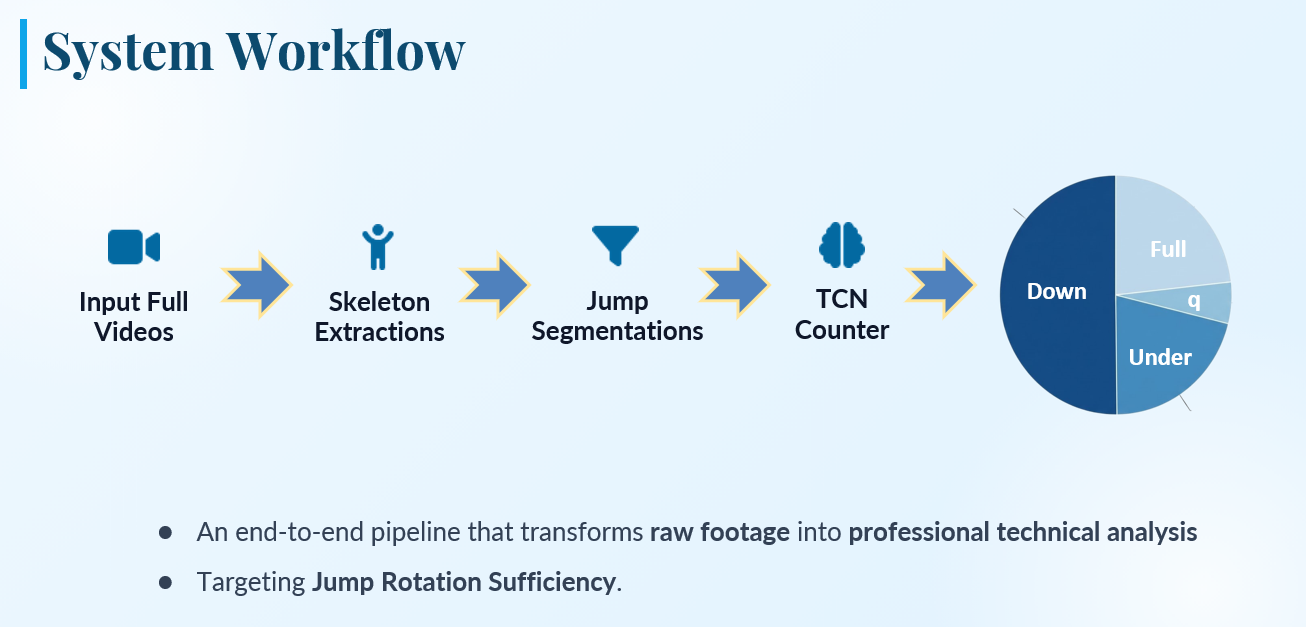

# Part A. Jump Segmentation

This part explains how we can obtain jump clips from a full program video of figure skating.

In a full program videos, we have jumps, spins, step sequences, choreography sequences and some other transitions. We need an automatic way to seperate jumps from the rest of the elements.

Related code can be found in Jump_candidates_segmentation.py. It can be run locally, only edits required are the video and output path. 

### Dataset:
Kaggle: 
https://www.kaggle.com/datasets/sarazany/figure-skating-underrotations-and-flutzlip/data
https://www.kaggle.com/datasets/betessawildenboer/lutz-jumps-dataset

Youtube Video:
2025 IDF WOMEN FS https://youtu.be/XlCM3GohF78
2025 IDF MEN FS https://youtu.be/ow7BhOBIk7A
2025 COC WOMEN FS https://youtu.be/sxbEiRGy8Z8
2025 COC MEN FS https://youtu.be/S1iE1Kh--HI
2025 NHK MEN FS https://youtu.be/deD0tqeaPoI

## 1. Skeleton Extraction
We run **MediaPipe Pose** on the full routine video at ~cache_fps to get skeleton keypoints, and save all **33 anatomical landmarks** into a compressed npz file.
- Model complexity for mediapipe pose is 1 here.

The cache will contain:
    keypoints: (T, 33, 4) array, [x, y, z, visibility], normalized [0,1]
    times:     (T,) time in seconds from start of video
    frame_idx: (T,) original frame index in the video
    metadata:  dict with video info and cache settings


We use the x and y coordinates for the following pose analysis. 

Related code can be found in the function **build_pose_cache**

## 2. Physics-Based Heuristics
Before using heavy AI models, we filter for potential jump segments based on figure skating physics

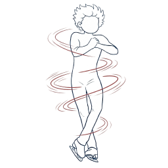
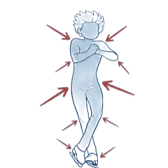


As we can see the jumps here, Skaters must minimize their moment of inertia to rotate, and the angular velocity is distinctive.

so we measure the tightness of limbs towards the central axis and the rotational speed to get the jump candidates.

### Here are the two-stage heuristic for jump candidate detection:

### Stage 1 (compactness):
        - Compute a "tucked limbs" compactness score:
            * Torso axis defined by mid-hips -> mid-shoulders.
            * Arms: wrists close to torso axis.
            * Legs: knees and ankles close to torso axis.
        - Rank frames by this compactness and keep the top compact_top_ratio.

### Stage 2 (rotation):
        - Compute body orientation angle in the image plane (using shoulders or hips).
        - Compute angular velocity |d(angle)/dt|.
        - Among the compact frames, keep the subset with highest angular velocity
          (rot_top_ratio).

### Then:
        - Group selected frames into temporal segments.
        - Extend, merge, and filter short segments.
        - Convert times back to original frame indices.

Related code can be found in the function **detect_jump_segments_by_compact_and_rotation_from_cache**  
Select the top 20% most compact frames and top 10% fastest-rotating among compact frames as the jump candidates. 
Then save jump clips and export the skeleton for each clip. Related code can be found in the function **save_segments_as_clips**


## 3. Two-Beanch LSTM Model for Binary Classification

Build a two-branch LSTM network for jumps & non-jumps classification.
The network combines both skeleton data and specific features, achieving 90% accuracy

### 3.1 Two-branch LSTM:
      - Branch 1: processes normalized joint coordinates.
      - Branch 2: processes engineered features.
      - Final head: merges both branches and predicts jump / non-jump.
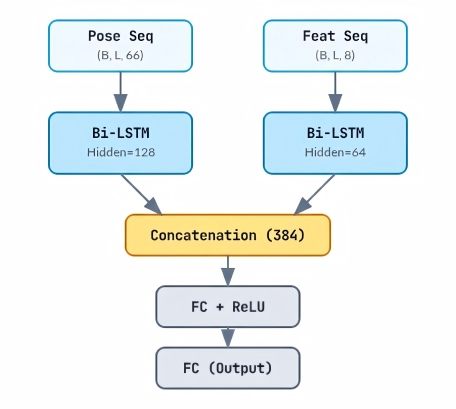

####  The feature list:
      - hip_up: hip height relative to baseline
      - ankle_up: ankle height relative to baseline
      - compact: how close arms/legs are to the body center
      - straight: trunk verticality
      - arms_up: hand height relative to shoulders
      - arms_front: hand forward distance to shoulders
      - abs_omega: absolute angular velocity (yaw rate)
      - ankle_angle: knee-ankle-toe angle in degrees (bigger in jumps, ~<=90 on ice)

Model code can be found in Building_LSTM_Model.py. 
Full Training and Testing record can be found in FS_LSTM_JUMP.ipynb

### 3.2 Train the LSTM Model and plot the training curves

### Dataset: 
https://drive.google.com/drive/folders/1T9triWuKSeDZ6JV0Kix9V7i4D7Pbf48o?usp=sharing

- [Dataset] Found 1251 jump clips, 1172 non-jump clips
- [Dataset] train samples: 1875
- [Dataset] val samples: 469
- [Info] pose_dim=66, feat_dim=8

In [ ]:
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from Building_LSTM_Model import TwoBranchLSTM, collate_fn, train_one_epoch, eval_one_epoch, FSClipsDataset, evaluate_on_labeled_test_set, predict_on_unlabeled_folder

# =========================
# Main training script
# =========================

if __name__ == "__main__":
    # DATA_ROOT/
    #   jumps/*.npz
    #   non-jumps/*.npz
    DATA_ROOT = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/lstm_data"

    batch_size = 16
    max_len = 64
    num_epochs = 30
    lr = 1e-3
    val_fraction = 0.2

    train_dataset = FSClipsDataset(
        root_dir=DATA_ROOT,
        split="train",
        val_fraction=val_fraction,
        random_seed=42
    )
    val_dataset = FSClipsDataset(
        root_dir=DATA_ROOT,
        split="val",
        val_fraction=val_fraction,
        random_seed=42
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=lambda b: collate_fn(b, max_len=max_len)
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=lambda b: collate_fn(b, max_len=max_len)
    )

    # Infer input dimensions from one sample
    sample_item = train_dataset[0]
    pose_dim = sample_item["pose_seq"].shape[1]
    feat_dim = sample_item["feat_seq"].shape[1]
    print(f"[Info] pose_dim={pose_dim}, feat_dim={feat_dim}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TwoBranchLSTM(
        pose_dim=pose_dim,
        feat_dim=feat_dim,
        pose_hidden=128,
        feat_hidden=64,
        num_layers=1,
        dropout=0.1
    ).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    # ---- lists to store history ----
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch {epoch:02d}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = os.path.join(DATA_ROOT, "best_two_branch_lstm.pt")
            torch.save(model.state_dict(), save_path)
            print(f"  -> New best model saved to {save_path} (val_acc={val_acc:.3f})")

    # ---- plot loss curves ----
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ---- plot accuracy curves ----
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### Best epoch:
Epoch 22: train_loss=0.0424, train_acc=0.982, val_loss=0.3781, val_acc=0.930
 -> New best model saved to /content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/lstm_data/best_two_branch_lstm.pt (val_acc=0.930)

 Training Curve
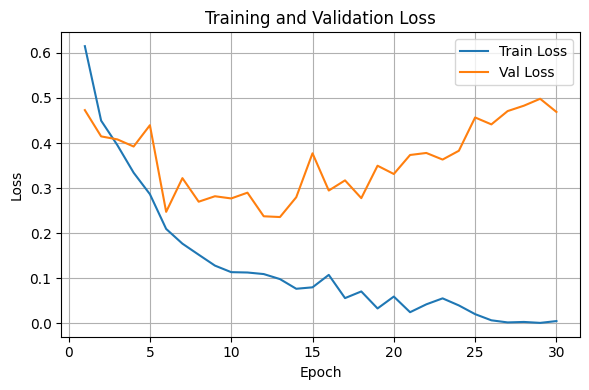
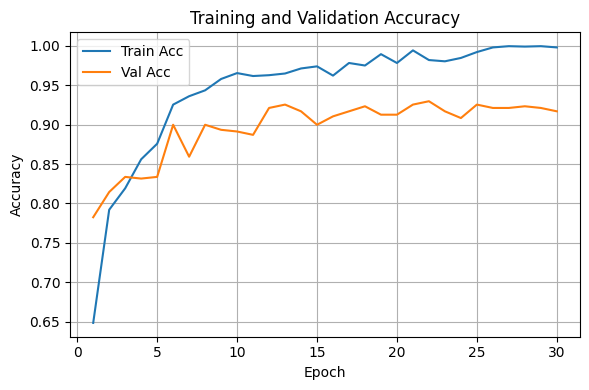

### 3.3 Load the best model for testing
We fine tuned several parameters and kept only the best one here.

In [ ]:
DATA_ROOT = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/lstm_data"
MODEL_PATH = os.path.join(DATA_ROOT, "best_two_branch_lstm.pt")

tmp_dataset = FSClipsDataset(
    root_dir=DATA_ROOT,
    split="train",
    val_fraction=0.2,
    random_seed=42,
)
sample_item = tmp_dataset[0]
pose_dim = sample_item["pose_seq"].shape[1]
feat_dim = sample_item["feat_seq"].shape[1]
print(f"[Info] pose_dim={pose_dim}, feat_dim={feat_dim}")

pose_hidden = 128
feat_hidden = 64
num_layers  = 1
dropout   = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TwoBranchLSTM(
    pose_dim=pose_dim,
    feat_dim=feat_dim,
    pose_hidden=pose_hidden,
    feat_hidden=feat_hidden,
    num_layers=num_layers,
    dropout=dropout
).to(device)

state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("[Info] Loaded model from", MODEL_PATH)


### 3.4 Evaluate on Test Dataset

In [ ]:
TEST_ROOT = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/2025SA_WOMEN_clip_coords_test"

test_acc, (tn, fp, fn, tp), buckets = evaluate_on_labeled_test_set(
    model=model,
    test_root=TEST_ROOT,
    device=device,
    max_len=64,
    batch_size=16,
    threshold=0.5,
    max_show_tp_tn=5,   # how many TP/TN examples to print
)


#### Results on Test Set:

[Test] Labeled test set size: 164
[Test] Accuracy: 0.921

[Confusion Matrix] (rows = true, cols = predicted)

                   
- true_non-jump:      pred_non-jump    74       pred_jump       8

- true_jump:          pred_non-jump    5       pred_jump      77

[Stats] Precision (jump class): 0.906
[Stats] Recall    (jump class): 0.939

### 3.5 Evaluate on Unlabeled new data

In [ ]:
UNLABELED_FOLDER = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/2025SA_WOMEN-seg11_clip_coords_unlabeled"

predict_on_unlabeled_folder(
    model=model,
    folder=UNLABELED_FOLDER,
    device=device,
    max_len=64,
    threshold=0.5,
)

#### Results:

18 jumps candidates, 7 real jumps, 11 non-jumps.

Only 1 non-jump is classified as jump, with probability of 0.502.
All jumps are successfully classified as jumps.

# Part B 
## 1. Data Preparation

This part explains the data sources we used, the structure of the data, and how we transformed the raw video data into skeletal features that could be used by the model.



### 1.1 Dataset Description

The dataset used in this project is the “Figure Skating Under-rotations and Flutz/Lip” dataset publicly available on [Kaggle](https://www.kaggle.com/datasets/sarazany/figure-skating-underrotations-and-flutzlip/data)
.


It consists of short video clips extracted from international figure skating competitions, categorized by specific technical judging issues such as under-rotations and flutz/lip errors.

For this project, we focus exclusively on the under-rotation subset.
This folder contains four subcategories corresponding to the degree of rotation completion, aligned with official ISU (International Skating Union) notation:



*   **0_full rotation:** Fully rotated jumps with no deductions

*   **1_on the quarter:** Slightly short (~¼ turn missing)

*   **2_underrotated:** Noticeably short (~¼–½ turn missing)

*   **3_downgraded:** Severely short (≥½ turn missing)


**Additional Data Source (Manual Annotation):**
To incorporate the latest high-level competition standards, we manually annotated and sliced the 2025 World Team Trophy Men Free Skating video (available [here](https://youtu.be/co7xNl9Wkuc)). These custom-sliced clips were integrated into the dataset to improve the model's exposure to top-tier technical executions.

**Data Preprocessing (Binary Classification):**
To focus on the detection of *any* rotation fault, we simplified the problem into a binary classification task. We applied the following mapping to group the labels:

* **Class 0 (Clean):** Includes `"full"`
* **Class 1 (Fault):** Merges `"q"`, `"under"`, and `"down"`

**Data Augmentation & Balancing:**
The original dataset presented a class imbalance. To address this, we applied data augmentation techniques (`data_augmentation.py` available in our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git)).
* **Mirroring (Horizontal Flip):** Creating new samples by flipping the jump direction.
* **Rotation:** Applying slight rotational variances to simulate different camera angles.

> **Final Dataset Status:**
> * **Class 0:** 500 samples
> * **Class 1:** 500 samples
> * **Total:** 1000 balanced samples

This combined and balanced dataset serves as the foundation for our deep learning model.

Despite these limitations, the dataset provides a valuable foundation for building a model that can learn under-rotation detection from real-world competition footage.


### 1.2 2D Pose Extraction (MediaPipe)

Accurately capturing the motion dynamics of a figure skating jump requires reliable skeletal information across time. 

- We first run MediaPipe Pose with model_complexity=1 on the full video to efficiently detect and localize candidate jump segments. After these segments are identified, we re-run Pose with the Heavy model (model_complexity=2) only on those short clips, because the higher-precision keypoints are more important for accurate rotation and technique analysis, while applying the Heavy model to the entire video would be computationally expensive and unnecessary.

**Code Availability:**
All data processing scripts are available in our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git).

To extract pose keypoints from raw videos, we use **MediaPipe Pose**, a deep-learning-based human pose estimation framework that detects **33 anatomical landmarks** per frame, which improves on the baseline MediaPipe Pose pipeline in three main ways:

1.   **Visibility Enhancement** — The skeleton is drawn using deeper, high-contrast colors (dark blue and dark red) with thicker lines to improve visibility
2.   **Reliability Filtering** — Early or low-confidence frames are automatically skipped or replaced with the last reliable pose, stabilizing the extracted sequence.
3.   **Standardized Output Format** — We provide two specific scripts for different needs:

*   `skeleton_video_extraction.py`: Use this if you want to **generate and visualize** the annotated videos with skeletal overlays (`_SK.mp4`).
*   `coords_extraction.py`: Use this if you only need to **process data** and extract the coordinate files (`_SK_coords.npz`) for model training.

The goal is to transform raw figure skate jump  clips into structured, standardized motion data suitable for statistical or machine-learning analysis.


### 1.3 Final Dataset

The preprocessing was executed offline to handle the large dataset efficiently and to ensure stable GPU-accelerated performance.  

The resulting keypoints were saved as `.npz` files, each containing a 3D tensor:

$$shape: (T, 33, 3) → (time, joints, [x, y, visibility])$$

These preprocessed files are now directly imported into our notebook for analysis and modeling, avoiding the need to rerun the computationally intensive pose extraction step.  

**Dataset Availability:**
The final balanced dataset, obtained through the steps above, is available at the following link: [Link to Dataset](https://drive.google.com/drive/folders/109k990G0kwnK4AUNeTZTw-EfT24T_YAT?usp=share_link).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


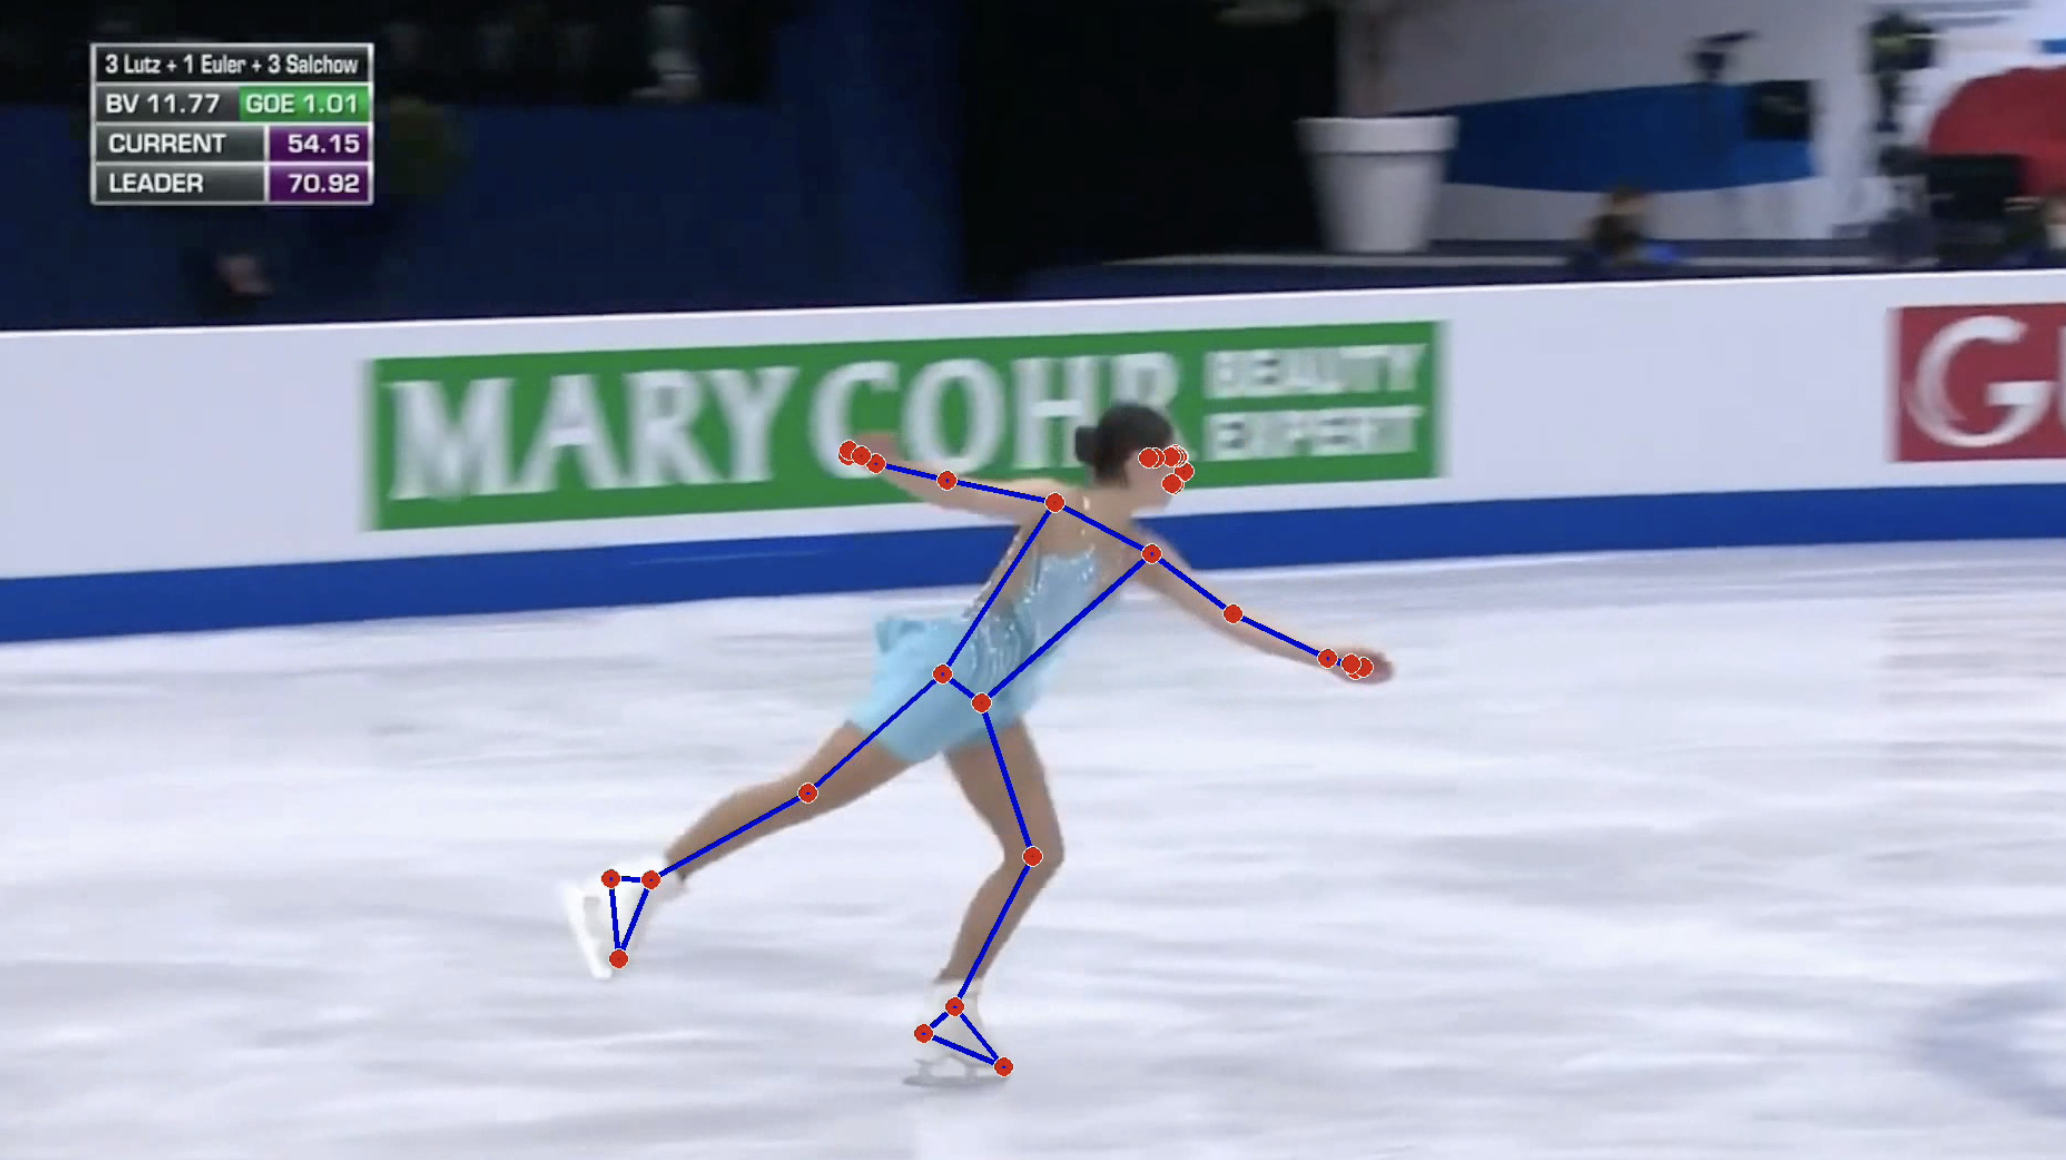

## 2. Model Architecture

Our challenge is to model how the human body moves through time — not just what it looks like in one frame. Subtle variations in timing, coordination, and joint trajectories often distinguish good rotations or landings from poor ones. Thus, the model must capture temporal dependencies: how earlier body positions influence later ones.

Among several models that can handle time series(i.e. RNN), we adopted **TCNs** because they combine efficiency, stability, and interpretability for medium-length motion sequences

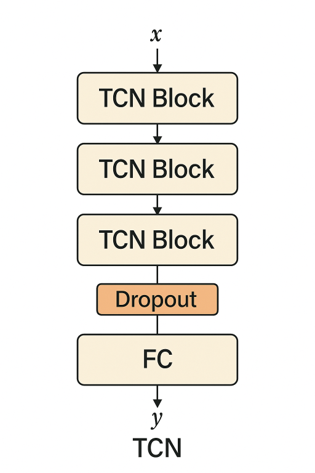

In [ ]:
try:
    import rich, torchmetrics  # noqa
except Exception:
    %pip -q install rich==13.7.1 torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.5 MB/s eta 0:00:00


In [ ]:
# Repro + imports (put this at the very top of your notebook)
import os, random, numpy as np
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # set before importing torch

random.seed(SEED)
np.random.seed(SEED)

import torch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

import glob, math, json, time
from typing import Dict, Tuple
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score
from torchmetrics.functional import accuracy
from rich import print

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


Load data from Google Drive and divide them into 4 subfolders: `full`, `q`, `under`, and `down`.

Emerge q, under and down into 1 class, marked as 1, suggesting there might be a certain degree of under-rotation.

Keep full as 0, suggesting no under-rotation.

In [ ]:
COORD_DIR = "/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/skeleton_coords_2"

NUM_CLASSES = 2
# MERGE_MAP = { "full": 0, "q": 1, "under": 1, "down": 2 }
MERGE_MAP = { "full": 0, "q": 1, "under": 1, "down": 1 }
T_TARGET = 64
BATCH_SIZE = 32
LR = 1e-3
WEIGHT_DECAY = 1e-2
MAX_EPOCHS = 105
MIN_EPOCHS   = 20
PATIENCE = 50
MIN_DELTA = 1e-3
SMOOTH_K = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In raw pixel space, the same movement can produce widely different coordinate scales depending on the camera's distance, zoom level, or framing. Without normalization, these spatial inconsistencies make it difficult for downstream models to learn meaningful motion patterns, as absolute positions vary across videos even for identical poses.

#### 1. Spatial Normalization
The spatial normalization consists of two steps:

- **Translation normalization**  
  All landmarks are shifted so that the midpoint between the left and right hips lies at the origin. This removes lateral and vertical offsets caused by different camera placements or subject positions.

- **Scale normalization**  
  Coordinates are divided by the **trunk height**, defined as the Euclidean distance between the shoulder midpoint (“neck”) and the mid-hip.  
  
#### 2. Temporal Resampling and Smoothing
To make time series uniform and reduce frame-level noise:

- **Linear resampling**  
  Each channel of the keypoint sequence is linearly interpolated from input length `T_in` to a target length `T_out`, ensuring consistent frame counts across samples.

- **3-frame moving average**  
  A simple smoothing filter is applied independently to each channel to reduce frame-to-frame jitter and produce smoother motion trajectories.


In [ ]:
NOSE = 0
L_SHOULDER, R_SHOULDER = 11, 12
L_HIP, R_HIP = 23, 24

def mid_hip_xy(frame):  # frame: [33,3] (x,y,vis)
    """Mid-hip (x, y)."""
    l = frame[L_HIP]; r = frame[R_HIP]
    return (l[0] + r[0]) / 2.0, (l[1] + r[1]) / 2.0

def trunk_height(frame):
    """Vertical trunk height using shoulder midpoint as neck."""
    ls, rs = frame[L_SHOULDER], frame[R_SHOULDER]
    neck = np.array([(ls[0] + rs[0]) / 2.0, (ls[1] + rs[1]) / 2.0])
    mhx, mhy = mid_hip_xy(frame)
    midhip = np.array([mhx, mhy])
    return np.linalg.norm(neck - midhip) + 1e-8

def linear_resample(arr, T_out):
    """Linear resample arr: [T_in, C] -> [T_out, C]."""
    T_in = arr.shape[0]
    if T_in == T_out:
        return arr
    xs = np.linspace(0, T_in - 1, num=T_in)
    xi = np.linspace(0, T_in - 1, num=T_out)
    out = np.empty((T_out, arr.shape[1]), dtype=arr.dtype)
    for c in range(arr.shape[1]):
        out[:, c] = np.interp(xi, xs, arr[:, c])
    return out

def smooth3(arr):
    """3-frame moving average per channel."""
    if arr.shape[0] < 3:
        return arr
    pad = np.vstack([arr[0:1], arr, arr[-1:]])
    kernel = np.array([1, 1, 1], dtype=np.float32) / 3.0
    out = np.zeros_like(arr)
    for c in range(arr.shape[1]):
        out[:, c] = np.convolve(pad[:, c], kernel, mode="valid")
    return out

Preprocess the skeleton sequences stored as .npz.

For each clip: load [T,33,3] keypoints → take XY, center each frame at mid-hip, scale by the median trunk height (neck–mid-hip) over time.

Smooth with a 3-frame moving average, add first-order differences as velocity. Then stardardize the position and velocity.


In [ ]:
class SimplePoseSeqDataset(Dataset):
    def __init__(self, coord_dir, t_target=64, class_map=None, train=True):
        self.paths = sorted(glob.glob(os.path.join(coord_dir, "*", "*.npz")))
        assert self.paths, f"No npz found under {coord_dir}/*/"
        self.t_target = t_target
        self.train = train
        self.class_map = class_map
        self.samples = []
        for p in self.paths:
            parent = os.path.basename(os.path.dirname(p)).strip().lower()
            if parent not in self.class_map:
                continue
            self.samples.append((p, self.class_map[parent]))
        assert self.samples, "No samples matched your MERGE_MAP under given coord_dir"

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path, y = self.samples[idx]
        z = np.load(path, allow_pickle=True)
        kp = z["keypoints"].astype(np.float32)          # [T,33,3]
        xy = kp[:, :, :2]                    # [T,33,2]
        T  = xy.shape[0]

        xy3 = kp
        for t in range(T):
            mx, my = mid_hip_xy(xy3[t])
            xy[t,:,0] -= mx; xy[t,:,1] -= my
        s_seq = np.median([trunk_height(xy3[t]) for t in range(T)]).astype(np.float32)
        xy /= (s_seq + 1e-8)

        seq = xy.reshape(T, -1)
        seq = smooth3(seq)
        vel = np.zeros_like(seq); vel[1:] = seq[1:] - seq[:-1]

        seq = linear_resample(seq, self.t_target)
        vel = linear_resample(vel, self.t_target)
        feat = np.concatenate([seq, vel], axis=1)  # [T,132]

        mean = feat.mean(axis=0, keepdims=True);
        std = feat.std(axis=0, keepdims=True) + 1e-6
        feat = (feat - mean) / std

        x = torch.from_numpy(feat.T).float()       # [C=132, T]
        y = torch.tensor(y).long()
        return x, y

### Temporal Convolutional Network (TCN)
Our project uses a Temporal Convolutional Network (TCN) designed
  specifically for analyzing sequential motion data. The model classifies jumps into rotation quality categories based
  on 2D pose keypoint sequences.
#### Key Features:
  - **Dialation**: Exponentially increasing dilation (1→2→4) captures
   multi-scale temporal patterns
  - **Residual connections**: Enables gradient flow and deeper architectures
  - **Dual pooling**: GAP captures average behavior, GMP captures peak features

  

In [ ]:
# Import TCN model from external module
from tcn_model import TinyTCN, TCNBlock


In [ ]:
# Import training functions from external module
from training import train_one_epoch, evaluate


## 3. Training
We now train the network to classify each motion sequence into its corresponding category.

### 3.1 Training Setup
The TCN model is trained using:

- Optimizer: **Adam**
- Loss function: **Cross-entropy loss**
- Batch size: 32
- Training epochs: until validation performance saturates
- Regularization:
  - Dropout in each TCN block
  - Early stopping based on validation loss

At each epoch, we compute:

- Training loss
- Validation loss
- Accuracy
- Macro F1-score
- Macro recall

This ensures both classification accuracy and class-wise fairness are monitored.


In [ ]:
def set_seed(seed=42):
    import os, random, numpy as np, torch
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
from tcn_model import TinyTCN

full_ds = SimplePoseSeqDataset(COORD_DIR, t_target=T_TARGET, class_map=MERGE_MAP, train=True)
labels = [lab for _, lab in full_ds.samples]

idx_all = np.arange(len(labels))
train_idx, test_idx = train_test_split(idx_all, test_size=0.20, stratify=labels, random_state=42)
train_idx, valid_idx = train_test_split(train_idx, test_size=0.20/0.80,
                                        stratify=np.array(labels)[train_idx], random_state=42)

valid_ds = Subset(SimplePoseSeqDataset(COORD_DIR, t_target=T_TARGET, class_map=MERGE_MAP, train=False), valid_idx)
test_ds  = Subset(SimplePoseSeqDataset(COORD_DIR, t_target=T_TARGET, class_map=MERGE_MAP, train=False),  test_idx)
train_ds = Subset(full_ds, train_idx)

SEED = 42
set_seed(SEED)
g = torch.Generator().manual_seed(SEED)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, generator=g)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True, generator=g)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True, generator=g)

y_train = np.array(labels)[train_idx]
cls_counts = np.bincount(y_train, minlength=NUM_CLASSES)
weights = (cls_counts.sum() / (cls_counts + 1e-6)); weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float32, device=DEVICE)

model = TinyTCN(c_in=132, num_classes=NUM_CLASSES, p_drop=0.2).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)

CKPT_DIR = "./ckpts"
os.makedirs(CKPT_DIR, exist_ok=True)

print("Train set size:", len(train_ds))
print("Valid set size:", len(valid_ds))
print("Test set size :", len(test_ds))


Train set size: 600

Valid set size: 200

Test set size : 200

### 3.2 Hyperparameter Tuning
To efficiently optimize model performance under limited computational budget, we use **Bayesian Optimization** for hyperparameter tuning.

Unlike grid search or random search, Bayesian Optimization builds a probabilistic surrogate model of the objective function and selects hyperparameters by maximizing an acquisition function. This allows the search process to focus on promising regions of the hyperparameter space with significantly fewer evaluations.

The optimization objective is defined as the **validation macro F1-score**, which ensures balanced performance across all four rotation classes.

In [ ]:
!pip install optuna

In [ ]:
# hyperparameter tuning using bayesian optimization
# Note: For F1-based tuning, use create_objective_f1 instead
# This example uses recall-based tuning
study = run_hyperparameter_tuning(objective, n_trials=100, direction="maximize")


In [ ]:
# retrain model using best params - macro f1
'''
Best Params:
{
    'lr': 0.0016209701238676817,
    'weight_decay': 0.00030666268037167634,
    'p_drop': 0.2903376136461604,
    'hidden_dim': 64,
    'kernel_size': 7
}
Best F1: 0.7931330255556397

'''

best_params = {
    'lr': 0.0016209701238676817,
    'weight_decay': 0.00030666268037167634,
    'p_drop': 0.2903376136461604,
    'hidden_dim': 64,
    'kernel_size': 7
}

model = TinyTCN(c_in=132,num_classes= NUM_CLASSES, p_drop=best_params["p_drop"]).to(DEVICE)
# (Only if you modified kernel_size search in objective)
model.block1.conv1.kernel_size = (best_params["kernel_size"],)
model.block2.conv1.kernel_size = (best_params["kernel_size"],)
model.block3.conv1.kernel_size = (best_params["kernel_size"],)

optimizer = torch.optim.AdamW(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])


In [ ]:
best_score, best_state = -1.0, None
best_epoch = -1
bad = 0
va_hist = []

for epoch in range(1, MAX_EPOCHS + 1):

    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc, va_f1, _, _, va_recall = evaluate(model, valid_loader)

    scheduler.step()

    va_hist.append(va_f1)
    smoothed = np.mean(va_hist[-SMOOTH_K:])

    print(
        f"Epoch {epoch:03d} | "
        f"tr_loss:{tr_loss:.4f} | va_loss:{va_loss:.4f} | "
        f"acc:{va_acc:.4f} | f1:{va_f1:.4f} | "
        f"recall:{va_recall:.4f} | smooth:{smoothed:.4f}"
    )
    # checkpoint
    torch.save(model.state_dict(), f"{CKPT_DIR}/epoch_{epoch:03d}.pt")

    # early stopping
    if epoch >= MIN_EPOCHS:
        if smoothed > best_score + MIN_DELTA:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print("Early stop.")
                break
    else:
        if smoothed > best_score:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch

print(f"Best epoch (smoothed): {best_epoch}, score={best_score:.4f}")

### Using Macro Recall


In [ ]:
# Import hyperparameter tuning functions from external module
from hyperparameter_tuning import create_objective_recall, run_hyperparameter_tuning

In [ ]:
## Using recall - Create objective function using imported module
objective = create_objective_recall(
    model_class=TinyTCN,
    c_in=132,
    num_classes=NUM_CLASSES,
    device=DEVICE,
    train_loader=train_loader,
    valid_loader=valid_loader,
    class_weights=class_weights,
    train_one_epoch=train_one_epoch,
    evaluate=evaluate,
    max_epochs=15
)


In [ ]:
# hyperparameter tuning using bayesian optimization
study = run_hyperparameter_tuning(objective, n_trials=100, direction="maximize")
# macro recall
# Best Params and Best Value are already printed by run_hyperparameter_tuning

In [ ]:
# retrain model using best params - macro recall
'''
Best Params:
{
    'lr': 0.003646345994963743,
    'weight_decay': 0.00020965476414117523,
    'p_drop': 0.10836702758036364,
    'hidden_dim': 64,
    'kernel_size': 5
}
Best Recall: 0.815
'''
# === Retrain model using best recall hyperparameters ===

best_params_r = {
    'lr': 0.003646345994963743,
    'weight_decay': 0.00020965476414117523,
    'p_drop': 0.10836702758036364,
    'hidden_dim': 64,
    'kernel_size': 5
}

# === Rebuild model ===
model_r = TinyTCN(
    c_in=132,
    num_classes=NUM_CLASSES,
    p_drop=best_params_r["p_drop"]
).to(DEVICE)

# === If kernel_size was tuned, apply it ===
model_r.block1.conv1.kernel_size = (best_params_r["kernel_size"],)
model_r.block2.conv1.kernel_size = (best_params_r["kernel_size"],)
model_r.block3.conv1.kernel_size = (best_params_r["kernel_size"],)

# === Define optimizer + scheduler ===
criterion_r = nn.CrossEntropyLoss(weight=class_weights)

optimizer_r = torch.optim.AdamW(
    model_r.parameters(),
    lr=best_params_r["lr"],
    weight_decay=best_params_r["weight_decay"]
)


# === Training loop ===
best_score, best_state = -1.0, None
best_epoch = -1
bad = 0
va_hist = []

for epoch in range(1, MAX_EPOCHS + 1):

    tr_loss = train_one_epoch(model_r, train_loader, optimizer_r, criterion_r)

    # Updated evaluate returns:
    # avg_loss, acc, f1_m, recall_m, preds, gts
    va_loss, va_acc, va_f1, _, _, va_recall = evaluate(model_r, valid_loader)

    scheduler.step()

    va_hist.append(va_recall)       # ⭐ Use recall for smoothing
    smoothed = np.mean(va_hist[-SMOOTH_K:])

    print(
        f"Epoch {epoch:03d} | "
        f"tr_loss:{tr_loss:.4f} | va_loss:{va_loss:.4f} | "
        f"acc:{va_acc:.4f} | f1:{va_f1:.4f} | "
        f"recall:{va_recall:.4f} | smooth:{smoothed:.4f}"
    )

    # --- Save checkpoint (using model_r!) ---
    torch.save(model_r.state_dict(), f"{CKPT_DIR}/epoch_{epoch:03d}.pt")

    # --- Early stopping (based on recall smoothing) ---
    if epoch >= MIN_EPOCHS:
        if smoothed > best_score + MIN_DELTA:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model_r.state_dict().items()}
            best_epoch = epoch
            bad = 0
        else:
            bad += 1
            if bad >= PATIENCE:
                print("Early stop.")
                break
    else:
        if smoothed > best_score:
            best_score = smoothed
            best_state = {k: v.detach().cpu().clone() for k, v in model_r.state_dict().items()}
            best_epoch = epoch

print(f"Best epoch (smoothed): {best_epoch}, score={best_score:.4f}")



## 4. Quantitative Results
This section reports the quantitative performance of our TCN-based rotation sufficiency classifier on the held-out test set.
### 4.1 Evaluation Metrics
We evaluate the model using the following metrics:

- **Accuracy**
- **Macro-averaged F1-score**
- **ROC-AUC**


In [ ]:
# Evaluate on Test
assert best_state is not None, "No best validation saved"
model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

te_loss, te_acc, te_f1, te_preds, te_gts, te_recall = evaluate(model, test_loader)
print(f"\n[bold green]TEST[/bold green] | loss {te_loss:.4f} | acc {te_acc:.4f} | macroF1 {te_f1:.4f} | recall {te_recall:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix (TEST):")
print(confusion_matrix(te_gts, te_preds))
print("\nClassification Report (TEST):")
print(classification_report(te_gts, te_preds, digits=4))

if NUM_CLASSES == 2:
    @torch.no_grad()
    def evaluate_proba(m, loader):
        m.eval()
        probs, gts = [], []
        for x,y in loader:
            x = x.to(DEVICE)
            p = m(x).softmax(-1).cpu().numpy()
            probs.append(p); gts += y.numpy().tolist()
        return np.vstack(probs), np.array(gts)

    from sklearn.metrics import roc_auc_score, average_precision_score
    te_prob, te_gts_arr = evaluate_proba(model, test_loader)
    pos_scores = te_prob[:, 1]
    roc_auc = roc_auc_score(te_gts_arr, pos_scores)
    pr_auc  = average_precision_score(te_gts_arr, pos_scores)
    print(f"\nROC-AUC (TEST): {roc_auc:.4f} | PR-AUC (TEST): {pr_auc:.4f}")

TEST | loss 1.7010 | acc 0.7350 | macroF1 0.7326 | recall 0.7350

Confusion Matrix (TEST):

[[64 36]
 [17 83]]

Classification Report (TEST):

precision    recall  f1-score   support

           0     0.7901    0.6400    0.7072       100
           1     0.6975    0.8300    0.7580       100

    accuracy                         0.7350       200
   macro avg     0.7438    0.7350    0.7326       200
weighted avg     0.7438    0.7350    0.7326       200

ROC-AUC (TEST): 0.8204 | PR-AUC (TEST): 0.8117

In [ ]:
# Evaluate on Test recall
assert best_state is not None, "No best validation saved"
model_r.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

te_loss, te_acc, te_f1, te_preds, te_gts, te_recall = evaluate(model_r, test_loader)
print(f"\n[bold green]TEST[/bold green] | loss {te_loss:.4f} | acc {te_acc:.4f} | macroF1 {te_f1:.4f} | recall {te_recall:.4f}")

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix (TEST):")
print(confusion_matrix(te_gts, te_preds))
print("\nClassification Report (TEST):")
print(classification_report(te_gts, te_preds, digits=4))

if NUM_CLASSES == 2:
    @torch.no_grad()
    def evaluate_proba(m, loader):
        m.eval()
        probs, gts = [], []
        for x,y in loader:
            x = x.to(DEVICE)
            p = m(x).softmax(-1).cpu().numpy()
            probs.append(p); gts += y.numpy().tolist()
        return np.vstack(probs), np.array(gts)

    from sklearn.metrics import roc_auc_score, average_precision_score
    te_prob, te_gts_arr = evaluate_proba(model, test_loader)
    pos_scores = te_prob[:, 1]
    roc_auc = roc_auc_score(te_gts_arr, pos_scores)
    pr_auc  = average_precision_score(te_gts_arr, pos_scores)
    print(f"\nROC-AUC (TEST): {roc_auc:.4f} | PR-AUC (TEST): {pr_auc:.4f}")

TEST | loss 1.4550 | acc 0.7450 | macroF1 0.7442 | recall 0.7450

Confusion Matrix (TEST):

[[80 20]
 [31 69]]

Classification Report (TEST):

precision    recall  f1-score   support

           0     0.7207    0.8000    0.7583       100
           1     0.7753    0.6900    0.7302       100

    accuracy                         0.7450       200
   macro avg     0.7480    0.7450    0.7442       200
weighted avg     0.7480    0.7450    0.7442       200

ROC-AUC (TEST): 0.8289 | PR-AUC (TEST): 0.8459

Epoch 77 was selected as the best checkpoint and used for testing.
On the test set, accuracy = 0.7450 and macro-F1 = 0.7442.

These results indicate that the model learns strong discriminative temporal features from pose-based motion data and generalizes well to unseen jump samples.


In [ ]:
# save the best weights
import os, pandas as pd
save_dir = "/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints"
os.makedirs(save_dir, exist_ok=True)

ckpt_path = os.path.join(save_dir, "tiny_tcn_best.pt")
torch.save({
    "model_state": best_state,
    "class_map": getattr(full_ds, "class_map", None),
    "config": {"T_TARGET": T_TARGET, "NUM_CLASSES": NUM_CLASSES, "LR": LR, "WEIGHT_DECAY": WEIGHT_DECAY}
}, ckpt_path)
print(f"\nSaved best checkpoint to {ckpt_path}")

pred_csv = os.path.join(save_dir, "test_preds.csv")
pd.DataFrame({"gt": te_gts, "pred": te_preds}).to_csv(pred_csv, index=False)
print(f"Saved test predictions to {pred_csv}")

Saved best checkpoint to /content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints/tiny_tcn_best.pt

Saved test predictions to /content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints/test_preds.csv

### 4.2 Video Prediction Visualization

We use a two-step pipeline to visualize model:
1.  **Inference:** Generate a CSV of predictions using the code below.
2.  **Visualization:** Overlay these predictions onto videos using `result_visualization.py`.

The script is available in our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git).

In [ ]:
import torch
import pandas as pd
import os

def export_predictions(model, dataset, output_file="predictions.csv"):
    """
    Runs inference on the dataset and saves predictions to a CSV file.
    Output columns: video_key, true_label, pred_label, confidence
    """
    print(f"Running inference on {len(dataset)} samples...")
    
    model.eval()
    device = next(model.parameters()).device
    results = []

    # Determine how to iterate (Standard ImageFolder vs Custom Dataset)
    if hasattr(dataset, 'samples'):
        iterator = enumerate(dataset.samples)
    elif hasattr(dataset, 'video_files'):
        iterator = enumerate(zip(dataset.video_files, dataset.labels))
    else:
        raise ValueError("Dataset format not recognized. Ensure it has .samples or .video_files")

    with torch.no_grad():
        for i, (path, true_label) in iterator:
            # Load data
            x, _ = dataset[i]
            x = x.unsqueeze(0).to(device)

            # Forward pass
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            pred_label = logits.argmax(dim=1).item()
            confidence = probs[0, pred_label].item()

            # Process filename to get video key
            # e.g. "video_01_SK_coords.npz" -> "video_01_SK"
            basename = os.path.basename(path)
            video_key = basename.replace("_coords.npz", "")
            
            if isinstance(true_label, torch.Tensor):
                true_label = true_label.item()

            results.append({
                "video_key": video_key,
                "true_label": int(true_label),
                "pred_label": int(pred_label),
                "confidence": confidence
            })

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

### 4.3 Model Evaluation & Visualization

To gain deeper insights into the model's decision-making process beyond simple accuracy metrics, we utilize a custom visualization module hosted on our [GitHub Repository](https://github.com/Sheweycs/FS-Jump-Rotation-Analysis.git).

The `Result_Compare_Visualization.py` script provides three critical analytical tools:

1.  **Error Analysis (`find_wrong_predictions`)**:
    * Identifies specific jump sequences where the model failed.
    * Helps correlate specific technical flaws (e.g., subtle quarter-rotation) with model errors.

2.  **Confidence Distribution (`test_confidence_distribution`)**:
    * Visualizes the density of the model's probability scores.
    * Allows us to see if the model is "confidently wrong" or if errors occur mostly in low-confidence (borderline) zones.

3.  **Feature Space Visualization (`visualize_tsne`)**:
    * Uses t-SNE (t-Distributed Stochastic Neighbor Embedding) to project the high-dimensional features extracted by the TCN into a 2D plane.
    * Demonstrates whether the model has successfully learned to cluster "Clean" (Class 0) and "Faulty" (Class 1) jumps in the latent space.

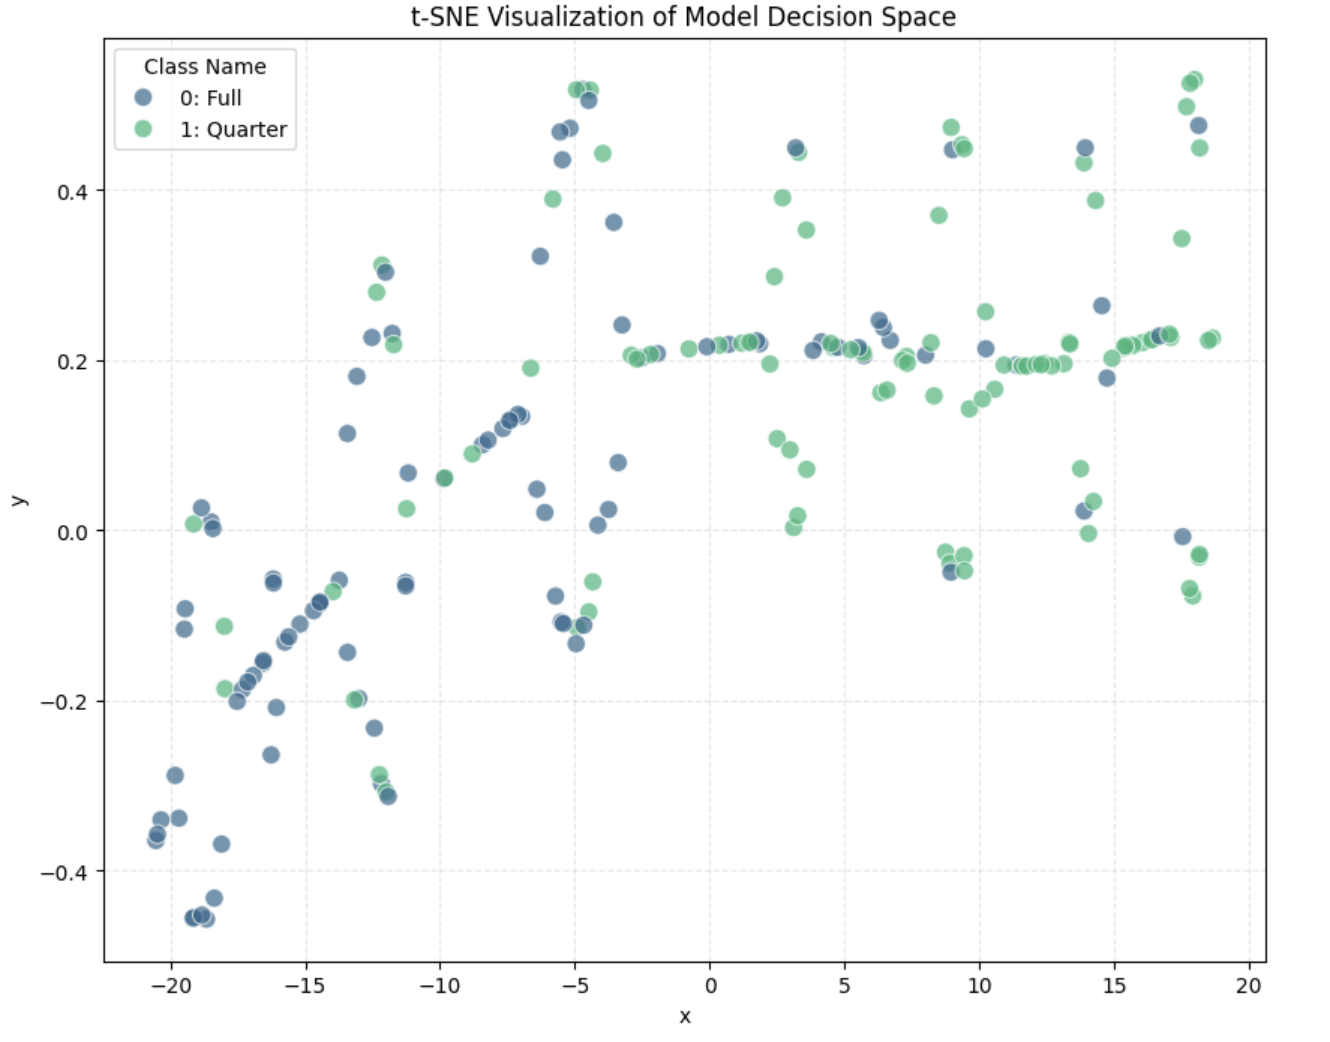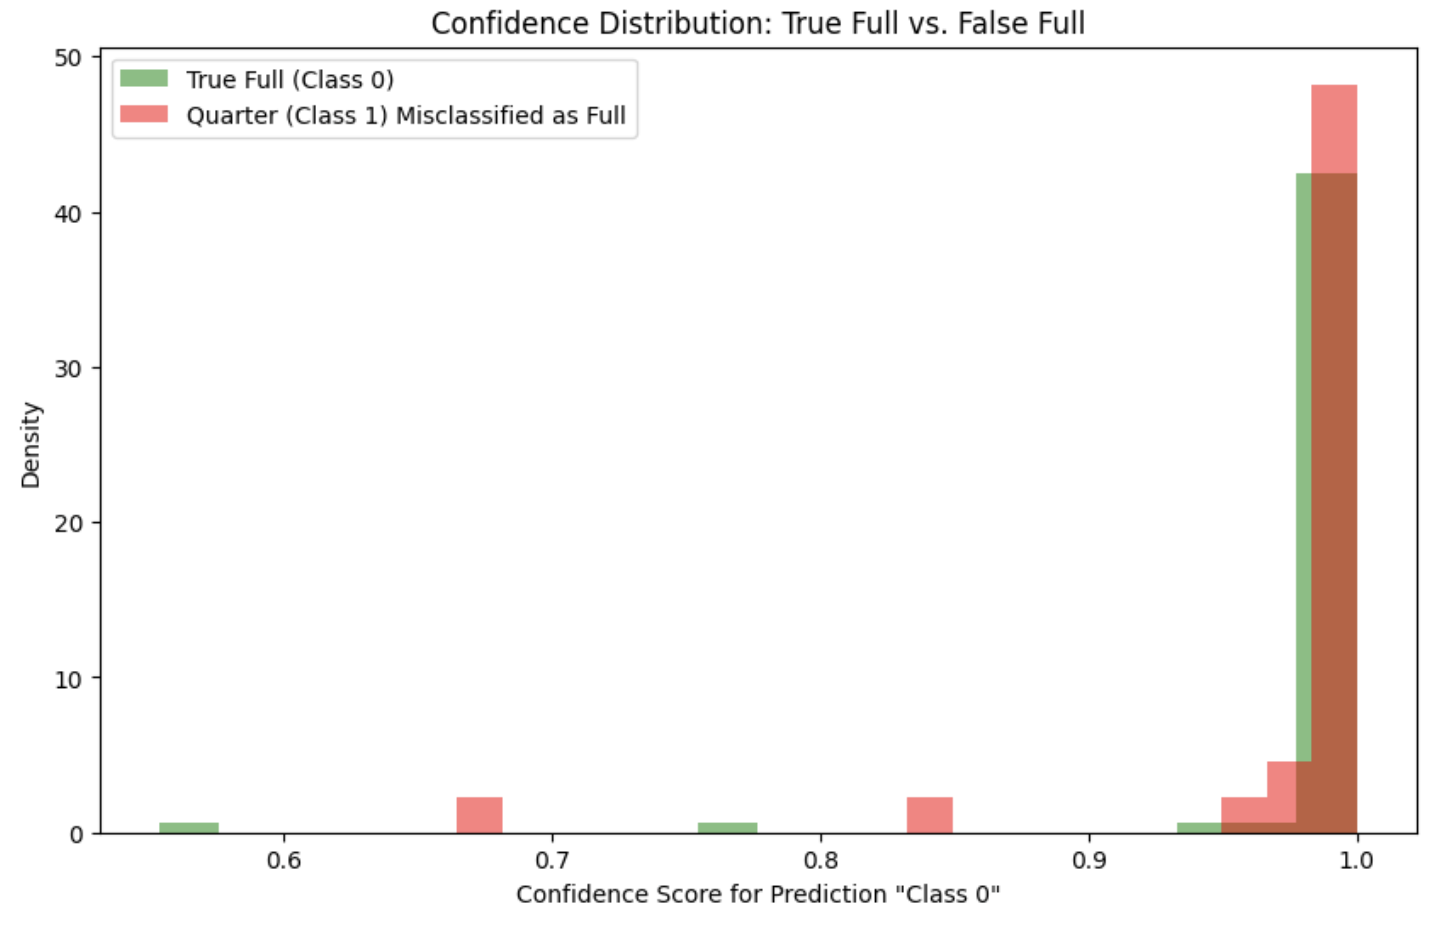

### 4.4 Evaluation on New Data

In [ ]:
import os
import glob
import numpy as np
import torch

def preprocess_npz_to_tensor(npz_path, t_target=64):
    """
    Load one skeleton npz and apply the same preprocessing
    as in SimplePoseSeqDataset, returning a tensor [1, C, T].
    """
    # Load npz, expect "keypoints" of shape [T, 33, 3]
    z = np.load(npz_path, allow_pickle=True)
    kp = z["keypoints"].astype(np.float32)   # [T, 33, 3]
    xy = kp[:, :, :2]                        # [T, 33, 2]
    T  = xy.shape[0]

    # 1) Translate so that mid-hip is at (0, 0)
    xy3 = kp  # reuse kp with visibility
    for t in range(T):
        mx, my = mid_hip_xy(xy3[t])
        xy[t, :, 0] -= mx
        xy[t, :, 1] -= my

    # 2) Scale by trunk height (median over time)
    s_seq = np.median([trunk_height(xy3[t]) for t in range(T)]).astype(np.float32)
    xy /= (s_seq + 1e-8)

    # 3) Flatten joints: [T, 33, 2] -> [T, 66]
    seq = xy.reshape(T, -1)

    # 4) Temporal smoothing with 3-frame moving average
    seq = smooth3(seq)

    # 5) Velocity features: first-order difference over time
    vel = np.zeros_like(seq)
    vel[1:] = seq[1:] - seq[:-1]

    # 6) Resample sequence and velocity to fixed length t_target
    seq = linear_resample(seq, t_target)
    vel = linear_resample(vel, t_target)

    # 7) Concatenate position and velocity: [T, 66+66] = [T, 132]
    feat = np.concatenate([seq, vel], axis=1)

    # 8) Per-sequence normalization (mean/std over time)
    mean = feat.mean(axis=0, keepdims=True)
    std  = feat.std(axis=0, keepdims=True) + 1e-6
    feat = (feat - mean) / std

    # 9) Convert to tensor [1, C, T] for the model
    x = torch.from_numpy(feat.T).float().unsqueeze(0).to(device)
    return x

def infer_single_npz(npz_path, t_target=64):
    """
    Run model inference on one npz file.
    Returns (predicted_class_index, probabilities_vector).
    """
    x = preprocess_npz_to_tensor(npz_path, t_target=t_target)  # [1, C, T]
    with torch.no_grad():
        logits = model(x)                      # [1, num_classes]
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        pred  = int(probs.argmax())
    return pred, probs

In [ ]:
import os
import glob
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Path to your best checkpoint
ckpt_path = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/checkpoints/tiny_tcn_best.pt"
state = torch.load(ckpt_path, map_location=device)

print("Checkpoint keys:", state.keys())

# ===== 1. Extract model_state and infer num_classes from weights/config =====
if "model_state" in state:
    model_state = state["model_state"]
elif "model" in state:
    model_state = state["model"]
else:
    model_state = state

# From weights (ground truth)
fc2_w = model_state["fc2.weight"]        # shape: [num_classes, 128]
num_classes_from_weight = fc2_w.shape[0]
print("fc2.weight shape in checkpoint:", fc2_w.shape)

# From config (also says 2)
cfg = state.get("config", {}) or {}
num_classes_from_cfg = cfg.get("NUM_CLASSES", num_classes_from_weight)
print("NUM_CLASSES in config:", num_classes_from_cfg)

# Final num_classes: trust the weights/config (both are 2 in your case)
num_classes = num_classes_from_cfg
print("=> Using num_classes:", num_classes)

# Just for reference: raw class_map (4 keys but 2 merged classes)
raw_class_map = state.get("class_map", None)
print("class_map in checkpoint:", raw_class_map)

# ===== 2. Define class index -> name (merged 2-class setting) =====
# You merged: full -> 0, q/under/down -> 1
IDX_TO_NAME = {
    0: "clean",
    1: "q/under/down",
}

# Safety: if for some reason num_classes != 2, fall back to generic
if num_classes != 2:
    IDX_TO_NAME = {i: f"class_{i}" for i in range(num_classes)}
    print("Warning: num_classes is not 2, using generic IDX_TO_NAME:", IDX_TO_NAME)
else:
    print("Using merged 2-class names:", IDX_TO_NAME)

# ===== 3. Build model and load weights =====
model = TinyTCN(
    c_in=132,          # 33 joints * 2 (xy) + 33 joints * 2 (vel) = 132
    num_classes=num_classes,
    p_drop=0.2         # must match training configuration
).to(device)

print("Fresh TinyTCN fc2 shape:", model.fc2.weight.shape)

model.load_state_dict(model_state)
model.eval()
print("Model loaded from:", ckpt_path)
print("Loaded fc2 shape:", model.fc2.weight.shape)

# ===== 4. Inference on all npz files under coord_dir =====

# Root directory containing new npz files (possibly with subfolders)
coord_dir = r"/content/drive/MyDrive/Colab Notebooks/FS_Rotation_Group9/2025SA_WOMEN_clips_test/Skeleton_Coords"

# Recursively find all *.npz under coord_dir
npz_files = glob.glob(os.path.join(coord_dir, "**", "*.npz"), recursive=True)
npz_files = sorted(npz_files)
print("Found npz files:", len(npz_files))

results = []

for p in npz_files:
    # infer_single_npz must be defined in a previous cell
    pred_idx, probs = infer_single_npz(p, t_target=64)
    pred_name = IDX_TO_NAME.get(pred_idx, str(pred_idx))
    print(f"{p} -> pred_idx={pred_idx}, pred_name={pred_name}, probs={probs}")
    results.append((p, pred_idx, pred_name, probs))

print("Inference finished.")


### 4.5 Discussion of Results

Based on the visualizations and error analysis generated above, we observe a distinct pattern in the model's performance, specifically regarding the boundary between **Class 0 (Clean/Full)** and **Class 1 (Faults)**.

**1. The "Full" vs. "Quarter" Challenge**
The t-SNE feature projection reveals that while the model easily distinguishes severe faults (such as "Downgraded" or obvious "Under-rotations") from clean jumps, there is significant overlap in the latent space between:
* **Full Rotation (Class 0)**
* **On the Quarter (Subset of Class 1)**

**2. Understanding the "Ambiguous Boundary" (Misclassification)**
Most errors occur in this specific overlap zone. Unlike distinct categories (e.g., a fall vs. a stand), the difference between a "Full" jump and a "Quarter" deduction is often a matter of less than 90 degrees of rotation.
* **Why errors happen:** The skeletal data for these two cases are mathematically extremely similar. The model struggles to find a sharp cutoff line because the visual "distance" between a clean landing and a slightly short landing is minimal.
* **Result:** Clean jumps are occasionally flagged as faults (False Positives), and subtle under-rotations are sometimes missed (False Negatives) because they sit on this fuzzy border.

**3. Conclusion & Hardware Improvements**
This difficulty mirrors human judging, where the "Quarter" call is notoriously subjective. To resolve this bottleneck and capture more useful information, future iterations should upgrade the data acquisition hardware:
* **Depth Cameras (e.g., LiDAR/Stereo):** To capture direct 3D depth information (Z-axis) rather than inferring it from 2D video, allowing for precise measurement of blade angles relative to the ice.
* **High-Definition & High-Frame-Rate Cameras:** To reduce motion blur during the fast landing phase, ensuring that the exact moment of impact is captured with sufficient clarity for the model to detect subtle rotation deficits.

**4. Future Directions**
We identify three main directions for improving our model: 
- **Real Time Analysis:** move from using pre-extracted skeleton sequences to integrating a real-time pose pipeline so that we can perform online jump segmentation and subsequent rotation-count detection; 
- **Key Frame Selection:** explicitly detect and extract the key take-off and landing frames, which are the most critical for determining whether the jump satisfies the required number of rotations according to judging rules; 
- **introducing ROI:** introduce a foot-focused ROI module to refine lower-limb joint estimation and correction, aiming for more accurate and robust scoring.

In [ ]:
%%shell
jupyter nbconvert --to html /content/FS_TCN.ipynb

[NbConvertApp] Converting notebook /content/FS_TCN.ipynb to html
[NbConvertApp] Writing 3861456 bytes to /content/FS_TCN.html
